# Model Explainability & Strategy Proposal

In [11]:
import joblib
import numpy as np
import pandas as pd
import shap

### SHAP

SHAP (SHapley Additive exPlanations) is a method used to explain how machine learning models make predictions.

SHAP assigns a value to each feature, showing how much it contributed to the prediction. It's based on Shapley values from game theory, where each feature is like a "player" in a game, and the final prediction is the "payout." SHAP calculates how to fairly split the payout (the prediction) among all the features.

Since SHAP expects both training and testing data to be already preprocessed, we cannot make use of our saved pipeline. We instead have to manually apply the preprocessor's transformation, and use the model to build the explainer.

In [12]:
model = joblib.load("../model/gradient_boost_model.pkl")
preprocessor = joblib.load("../model/preprocessor.pkl")
train_df = pd.read_excel("../data/train_data.xlsx", index_col=0)
test_df = pd.read_excel("../data/test_data.xlsx", index_col=0)

y_train = train_df["Churn"]
X_train = train_df.drop(columns=["Churn"])

y_test = test_df["Churn"]
X_test = test_df.drop(columns=["Churn"])

# SHAP needs all already preprocessed: that is the reason why we cannot use the pipeline itself
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Preprocessing loses column names. We can fix this by making a new df
feature_names = preprocessor.get_feature_names_out()
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=feature_names)

shap.initjs()

 99%|===================| 1394/1408 [00:27<00:00]        

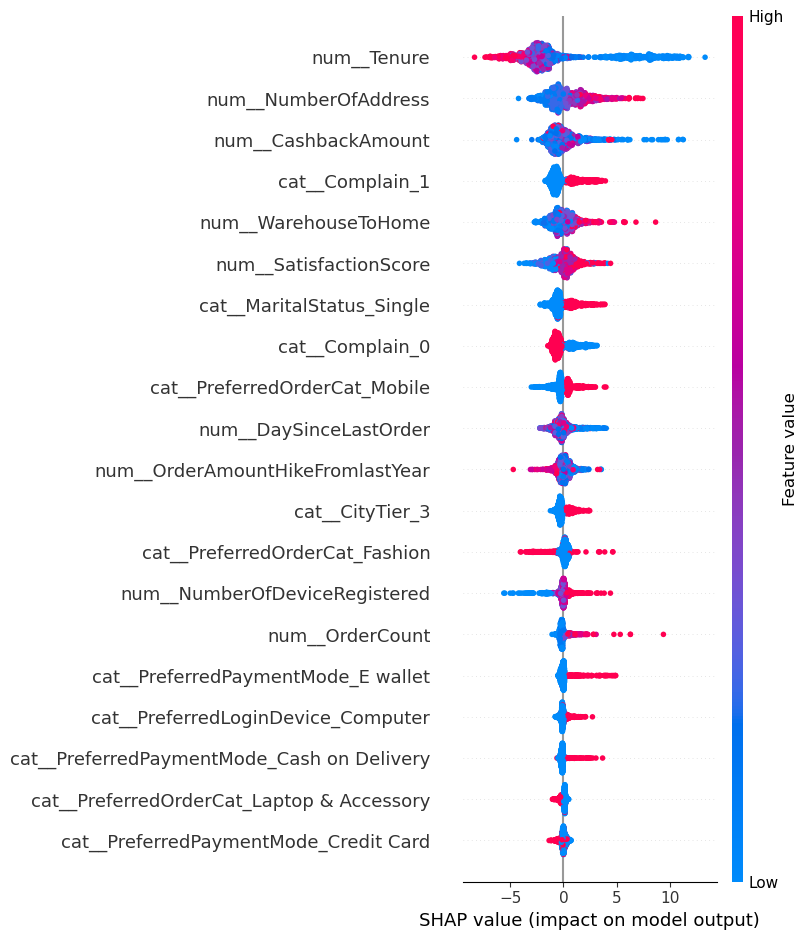

In [13]:
explainer = shap.Explainer(model, X_train_preprocessed)
shap_values = explainer(X_test_preprocessed_df) 

shap.summary_plot(shap_values, X_test_preprocessed_df)

The SHAP summary plot is ordered in feature importance. `Tenure` is the most influencing feature, and inexpectedly `NumberOfAddress` is right after. Remember that in the correlation matrix, with `Churn` it had a (linear) correlation of 0.044 (against -0.34 of `Tenure`). 

# Summary of actions the CMO can take to reduce churn rate

### 1. At-Risk Segments

`Tenure` and `NumberOfAddress` imply that newer customers or those who've moved a lot are more likely to churn. 

> Strategy: Create onboarding campain and loyalty programs for early-tenure customers. Offer stability-based incentives for highly mobile ones.
> 
> e.g. We expect movers to lean into home utilities. Give discounts on these products. Also consider offering free service delivery.

### 2. Targeted Communication Based on Complaints

`Complain` is quite high in the list. Solving customer dissatisfaction will definitely reduce churn rates. 

> Strategy: For customers who have complained, implement follow-up protocols with personalized resolutions. For those who haven’t, proactively reach out to build engagement before issues arise.
>
> e.g. Write an email focusing on empathy, accountability, and give an offer to turn dissatisfaction into loyalty (offers, discounts, ...).

### 3. Behavior-Based Personalization

`MaritalStatus` and `PreferredOrderCat` suggest behavioral patters linked to demographics. 

> Strategy: Consider investing on recommender systems to make personalized offers. Single individuals might respond differently to promotions than families or couples.
>
> e.g. Singles are more likely to churn in our data. Monitor their preferences, or give them more weight than normal when making recommendations.

### 4. Cashback Amount Trap

`CashbackAmount` is centered around 0 SHAP value, but a blue trail leans into higher SHAP values. This tell us that low Cashback amount leads to higher churn rate, but high Cashback amount does not reduce it significantly either. Perhaps consider different incentives?

### 5. Low City Tier Intervention

Customers in `CityTier` 3 are more likely to churn than one in a tier 1 City. Maybe make some research about regional preferences, and give bonuses through referral.

